<a href="https://colab.research.google.com/github/antoinexp/markov-chains-COM-516/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is provided as a starting point to help you generate random instances G1 and G2 as mentioned in the handout.

You are free to use and modify it at your own convenience.

---



In [126]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [127]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()
  
  def refresh(self):
    raise Exception("undefined")

In [128]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [129]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

### Uniform distribution ($\mathcal U([0,1])$)

In [130]:
g1 = G1()

Examples:

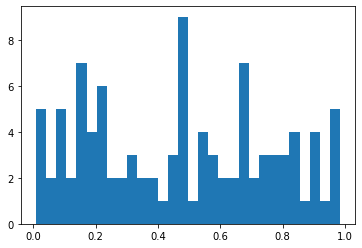

In [131]:
# Plot a histogram of the v array
plt.hist(g1.v, bins=30)
plt.show()

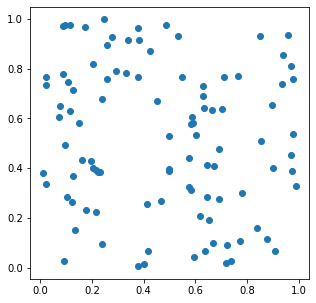

In [132]:
# plot the position of the points
plt.figure(figsize=(5,5))
plt.scatter(g1.x[:,0], g1.x[:,1])
plt.show()

You can refresh the dataset

In [133]:
g1.refresh() # generate a new dataset

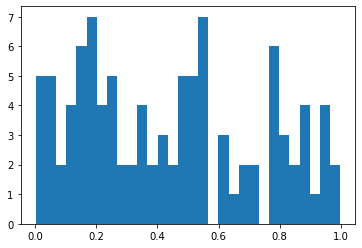

In [134]:
plt.hist(g1.v, bins=30)
plt.show()

Or for instance, you can generate 10 instances and compute the average position of all the points:

In [135]:
m = np.array([0., 0.])

for _ in range(10):
  g1.refresh() # refresh the dataset
  m  += 0.1*g1.x.mean()

print(m)

[0.50520546 0.50520546]


### Test on log-normal distribution

In [136]:
g2 = G2()

Example:

you can use g2 to generate an instance of the lognormal distribution

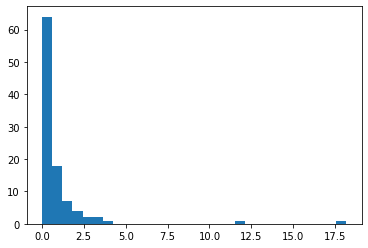

In [137]:
plt.hist(g2.v, bins=30)
plt.show()

In [138]:
g2.refresh() # to generate a new x and v

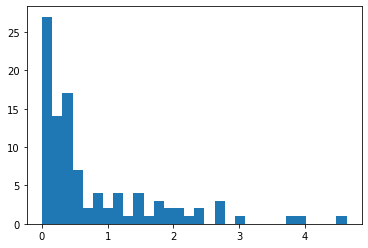

In [139]:
plt.hist(g2.v, bins=30)
plt.show()

---

### Metropolis Hastings

#### Useful functions

In [140]:
# an optimal beta as said in the course, could be interesting to use it
def computeBeta(N0,N1,f0,f1,epsilon):
    beta=log(N1/(epsilon*N0))/(f1-f0)
    return beta

In [141]:
# mobility of the team=smallest circle enclosing all cities in S
def maxArea(citiesX,selectedCities): #use of meshgrid could be better
    n=citiesX.shape[0]
    result=np.zeros((n,n))
    for i in range (n):
        for j in range (n):
            if selectedCities[i]==1 and selectedCities[j]==1:
                result[i,j]=(citiesX[i,0]-citiesX[j,0])*(citiesX[i,0]-citiesX[j,0])+(citiesX[i,1]-citiesX[j,1])*(citiesX[i,1]-citiesX[j,1])
    maxR=np.amax(result)
    #print('maxR'+str(maxR))
    #print(np.pi*maxR/4)
    return np.pi*maxR/4
    

In [142]:
def objectiveFunction(N,l,citiesV,selectedCities): #let's choose -F(lambda,S), so that we are minimizing and not maximizing
    f=0
    for i in range (N):
        if selectedCities[i]:
            f+=citiesV[i]
    f=f-l*N*maxArea(citiesX,selectedCities)
    return -f
    

In [143]:
def acceptancePb(selectedCities_i,selectedCities_j,beta,N,l,citiesV):
    fi=objectiveFunction(N,l,citiesV,selectedCities_i)
    fj=objectiveFunction(N,l,citiesV,selectedCities_j)
    result=np.exp(-beta*(fj-fi))
    return min(1,result)

In [144]:
def pbij(selectedCities_i,selectedCities_j,beta,N,l,citiesV): # not used in the algorithm, could be useful to plot and compare statistics
    if(selectedCities_i==selectedCities_j):
        s=0
        for k in range (N):
            selectedCities_k=np.copy(selectedCities_i)
            selectedCities_k[k]=1-selectedCities_i[k]
            a_ik=acceptancePb(selectedCities_i,selectedCities_k,beta,n,l,citiesV)
            phi_ik=(1/2)*(1/N)
            s+=phi_ik*a_ik
        return 1-s
    else:
        a_ij=acceptancePb(selectedCities_i,selectedCities_j,beta,n,l,citiesV)
        phi_ij=(1/2)*(1/N) #pb of chosing a city*pb choosing if 0 or 1
        return a_ij*phi_ij
    

In [145]:
def plotStatistics(): #useful to see the evolution of the number of cities selected and the f function
    return

#### The Algorithm

In [151]:
#parameters
l=0.3 #lambda in [0,1]
beta=100

#initialization
N=100
n_selected=0
g=G1(N)
citiesX=g.x
citiesV=g.v

#selectedCities=np.zeros(N,dtype=int) #table, 1 if city selected, 0 else

**Algorithm:**
1. Start from a random distribution
2. Select a city uniformly at random
3. choose if city had to be in the set, meaning selectedCities should be set to 0 or 1 (pb 1/2)
4. Accept or not that choice for that city, using the acceptance pb
5. Repeat (for a fixed number of times m)

Here is step 2,3,4:

In [147]:
# Step 2,3,4 
def step(N,citiesX,citiesV,selectedCities_i,beta,l):
    k=np.random.randint(0,N);
    rdm=np.random.rand()
    if rdm<0.5: #set 0, city not in set
        if selectedCities_i[k]==0: #same state then before
            return selectedCities_i #do nothing, it is accepted
        else:
            selectedCities_k=np.copy(selectedCities_i)
            selectedCities_k[k]=0 #city removed from set
            a_ik=acceptancePb(selectedCities_i,selectedCities_k,beta,N,l,citiesV) 
            rdm=np.random.rand()
            if rdm<a_ik:
                return selectedCities_k #accepted!
            else:
                return selectedCities_i #refused
    else: #set 1, city in set
        if selectedCities_i[k]==1: #do nothing, city already in set
            return selectedCities_i
        else:
            selectedCities_k=np.copy(selectedCities_i)
            selectedCities_k[k]=1 #add city to set
            a_ik=acceptancePb(selectedCities_i,selectedCities_k,beta,N,l,citiesV) #could of course be computed in a smarter way
            rdm=np.random.rand()
            if rdm<a_ik:
                return selectedCities_k #city added!
            else:
                return selectedCities_i #refused


New run

In [152]:
M=1000 #number of iterations

selectedCities_0=np.random.randint(2, size=(N)) #initial state

fs=np.zeros(M) #keep record of objective function (in fact, minus objective function)
fs[0]=objectiveFunction(N,l,citiesV,selectedCities_0)

print(selectedCities_0)
print('f1 '+ str(fs[0]))

selectedCities_n=np.copy(selectedCities_0)

for m in range (M):
    if(m%(M//10)==0):
        print(m)
#         fs[m//10]=objectiveFunction(N,l,citiesV,selectedCities_0) #could be useful if too many M
    fs[m]=objectiveFunction(N,l,citiesV,selectedCities_n)
    selectedCities_n=step(N,citiesX,citiesV,selectedCities_n,beta,l)
    
print (selectedCities_n)
print('fM '+ str(fs[M-1]))

[0 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 0 1 1
 1 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0]
f1 9.649219550657243
0
100
200
300
400
500
600
700
800
900
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
fM -21.803895185685825


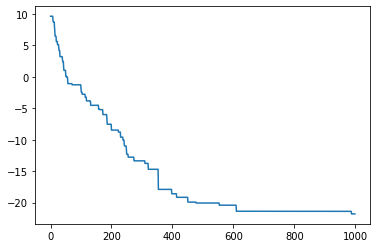

In [153]:
m=np.arange(M)
plt.plot(m,fs)

**Discussion:**
* convergence in terms of beta ?
* Choice of beta? Small then large, or use the optimal beta of the course (need precomputation?)
* Run the simulation many times? Then pick the min? Or do simulated annealing (with different beta)

**To be added:**
* statistics and visualization
